<a href="https://colab.research.google.com/github/seki-shu/Group15_Multimodal/blob/Robosuite/Robosuite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Robosuiteの基本

## Import libraries

In [4]:
%pip install robosuite

import robosuite as suite
import time
import pandas as pd
import matplotlib.pyplot as plt
import moviepy.editor as mpy
from base64 import b64encode
from IPython.display import HTML
from google.colab import files
import uuid, shutil
from typing import List
import numpy as np

import os

  if event.key is 'enter':



## シミュレーション環境の初期化

In [10]:
# 環境の初期化
env = suite.make(
    env_name="Lift",  # タスク名（Liftタスク）
    robots="Panda",   # 使用するロボット（Pandaロボット）
    has_renderer=False,  # リアルタイムレンダリングを有効にする
    use_camera_obs=True  # カメラ観測を使用しない
)
# 環境のリセット
obs = env.reset()


[robosuite INFO] Loading controller configuration from: /usr/local/lib/python3.10/dist-packages/robosuite/controllers/config/robots/default_panda.json (composite_controller_factory.py:69)
INFO:robosuite_logs:Loading controller configuration from: /usr/local/lib/python3.10/dist-packages/robosuite/controllers/config/robots/default_panda.json
[robosuite INFO] Loading controller configuration from: /usr/local/lib/python3.10/dist-packages/robosuite/controllers/config/robots/default_panda.json (composite_controller_factory.py:69)
INFO:robosuite_logs:Loading controller configuration from: /usr/local/lib/python3.10/dist-packages/robosuite/controllers/config/robots/default_panda.json


## アクションの実行

Observation: odict_keys(['robot0_joint_pos_cos', 'robot0_joint_pos_sin', 'robot0_joint_vel', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_eef_quat_site', 'robot0_gripper_qpos', 'robot0_gripper_qvel', 'agentview_image', 'cube_pos', 'cube_quat', 'gripper_to_cube_pos', 'robot0_proprio-state', 'object-state'])


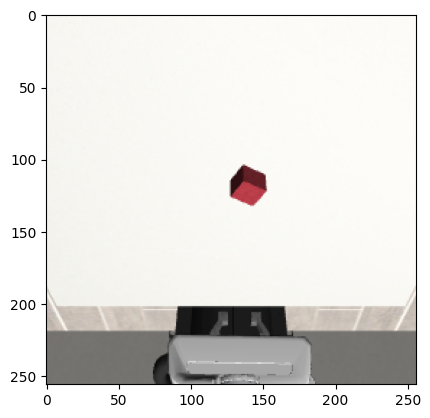

Reward: 0.0
Done: False


In [12]:
# アクションスペックを取得
action_spec = env.action_spec

# アクションの最小値と最大値を取得
low, high = action_spec

# ランダムなアクションを生成
action = np.random.uniform(low, high)

# アクションを実行し、次の状態、報酬、終了フラグ、情報を取得
obs, reward, done, info = env.step(action)

# 実行結果を表示
print("Observation:", obs.keys())
plt.imshow(obs["agentview_image"]); plt.show()
print("Reward:", reward)
print("Done:", done)

# マルチモーダル情報を扱えるRobosuite

## Import libraries

In [ ]:
%pip install robosuite
%pip install gymnasium

import torch
from torch import nn
from torch.nn import functional as F
import torch.distributions as td
from torch.distributions import Normal, Categorical, OneHotCategorical, OneHotCategoricalStraightThrough, Bernoulli
from torch.distributions import kl_divergence
import robosuite as suite
from robosuite.wrappers.gym_wrapper import GymWrapper

import numpy as np

import os

## Liftタスクの設定

In [ ]:
# 環境の初期化
env = suite.make(
    env_name="PickPlace",  # タスク名
    robots="Panda",   # 使用するロボット
    has_renderer=False,  # リアルタイムレンダリング
    has_offscreen_renderer=True,  # オフスクリーンレンダリング
    use_camera_obs=True,  # カメラ情報を使用
    camera_names=["frontview", "robot0_eye_in_hand"],  # 複数カメラ
    camera_heights=84,  # カメラ画像の高さ
    camera_widths=84,  # カメラ画像の幅
    camera_depths=False,  # 深度画像をオフ
    use_object_obs=True,  # オブジェクト情報を使用
    use_force_sensor=True
)

# GymWrapperを使ってOpenAI Gym互換インターフェースに変換
# env = GymWrapper(env)

# 環境のリセット
obs = env.reset()
# 環境の初期状態（力覚データを含む場合、"robot0_eef_force"を確認）
print("Observation:", obs.keys())  # 力覚データが含まれていることを確認

## Check device

In [ ]:
# torch.deviceを定義．この変数は後々モデルやデータをGPUに転送する時にも使います
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

## マルチモーダルデータの取得

In [ ]:
low, high = env.action_spec

# ランダムなアクションを生成
action = np.random.uniform(low=low, high=high, size=low.shape)

# 環境を1ステップ進める
obs, reward, done, info = env.step(action)

# 取得可能な情報を表示
print("Camera Observation:", obs["frontview_image"].shape)  # カメラ画像
# print("Force Sensor Data:", obs["robot0_eef_force"])  # 力覚データ
print("Object Position:", obs["cube_pos"])  # オブジェクトの位置

## set_seed

# モデルの実装


## RSSM

In [ ]:
class RSSM(nn.Module):
    """
    RSSMのクラス.

    Methods:
    --------
        recurrent: 決定的状態hをrnnで得る.
        get_prior: 確率的状態zの事前分布を得る.
        get_posterior: 確率的状態zの事後分布を得る.
    """
    def __init__(self, mlp_hidden_dim: int, h_dim: int, z_dim: int, a_dim: int, n_classes: int, embedding_dim: int):
        """
        コンストラクタ.

        Params:
        --------
            mlp_hidden_dim : int
               mlpに通した後の次元数.
            h_dim : int
               決定的状態hの次元数.
            z_dim : int
               確率的状態zの次元数.
            a_dim : int
               行動の次元数.
            n_classes : int
               確率的状態zのカテゴリ数.
            embedding_dim : int
               観測画像の埋め込み次元数.
        """
        super().__init__()

        self.h_dim = h_dim
        self.z_dim = z_dim
        self.a_dim = a_dim
        self.n_classes = n_classes

        # Recurrent model
        # h_t = f(h_t-1, z_t-1, a_t-1)
        self.z_a_hidden = nn.Linear(z_dim * n_classes + a_dim, mlp_hidden_dim)
        self.rnn = nn.GRUCell(mlp_hidden_dim, h_dim)

        # Prior prediction
        # z_t+1_hat = f(h_t+1)
        self.prior_hidden = nn.Linear(h_dim, mlp_hidden_dim)
        self.prior_logits = nn.Linear(mlp_hidden_dim, z_dim * n_classes)

        # Posterior
        # z_t+1 = f(h_t+1, o_t+1)
        self.posterior_hidden = nn.Linear(h_dim + embedding_dim, mlp_hidden_dim)
        self.posterior_logits = nn.Linear(mlp_hidden_dim, z_dim * n_classes)

    def recurrent(self, h_prev: torch.Tensor, z_prev: torch.Tensor, a_prev: torch.Tensor, rnn_hidden: torch.Tensor):
        """
        決定的状態の状態遷移を求めるメソッド. RNNとしてGRUを使用する.
        h_t+1 = f(h_t, z_t, a_t)

        Params:
        -------
            h_prev : torch.Tensor (batch size, h_dim)
                現在時刻の決定的状態h_t
            z_prev : torch.Tensor (batch size, z_dim)
                現在時刻の確率的状態z_t
            a_prev : torch.Tensor (batch size, a_dim)
                現在時刻のアクションa_t

        Returns:
        -------
            h : torch.Tensor (batch size, h_dim)
                次時刻の決定的状態h_t+1
        """
        mlp_hidden = F.elu(self.z_a_hidden(torch.cat([z_prev, a_prev], dim=1)))
        h = self.rnn(mlp_hidden, rnn_hidden)
        return h

    def get_prior(self,h: torch.Tensor, detach = False):
        """
        確率的状態zの事前分布を求めるメソッド.
        z_t+1_hat ~ p(h_t+1)

        Params:
            h : torch.Tensor (batch size, h_dim)
                次時刻の決定的状態h_t+1.
            detach : bool
                Trueの場合、detachする.

        ---------
        Returns:
            prior : torch.distributions.Distribution
                事前分布を求めるためのカテゴリカル分布.
            detached_prior : torch.distributions.Independent
                detachされた事前分布を求めるためのカテゴリカル分布.
        """
        mlp_hidden = F.elu(self.prior_hidden(h))
        logits = self.prior_logits(mlp_hidden) # (B, z_dim * n_classes,)
        logits = logits.reshape(logits.shape[0], self.z_dim, self.n_classes) # (B, z_dim, n_classes)

        prior = td.Independent(OneHotCategoricalStraightThrough(logits=logits), 1)
        if detach:
            detached_prior = td.Independent(OneHotCategoricalStraightThrough(logits=logits.detach()), 1)
            return prior, detached_prior
        return prior

    def get_posterior(self, h: torch.Tensor, embedded_obs: torch.Tensor, detach = False):
        """
        確率的状態zの事後分布を求めるメソッド.
        z_t+1 ~ p(h_t+1, o_t+1)

        Params:
        -------
            h : torch.Tensor (batch size, h_dim)
                次時刻の決定的状態h_t+1.
            embedded_obs : torch.Tensor (batch size, embedding_dim)
                次時刻の画像の埋め込み
            detach : bool
                Trueの場合、detachする.

        Returns:
        --------
            posterior : torch.distributions.Distribution
                事後分布を求めるためのカテゴリカル分布.
            detached_posterior : torch.distributions.Independent
                detachされた事後分布を求めるためのカテゴリカル分布.
        """
        mlp_hidden = F.elu(self.posterior_hidden(torch.cat([h, embedded_obs], dim=1)))
        logits = self.posterior_logits(mlp_hidden) # (B, z_dim * n_classes)
        logits = logits.reshape(logits.shape[0], self.z_dim, self.n_classes) # (B, z_dim, n_classes)

        posterior = td.Independent(OneHotCategoricalStraightThrough(logits=logits), 1)
        if detach:
            detached_posterior = td.Independent(OneHotCategoricalStraightThrough(logits=logits.detach()), 1)
            return posterior, detached_posterior
        return posterior

## Encoder

In [ ]:
class Encoder(nn.Module):
    """
    画像(3, 64, 64)をエンコードする.

    Methods:
    -------
        forward: 観測画像を埋め込む.
    """
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2)

    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        """
        順伝播を行うメソッド．観測画像をベクトルに埋め込む．
        (3, 64, 64) -> (1024, ) にエンコード

        Params:
        -------
            obs : torch.Tensor (batch size, 3, 64, 64)
                環境から得られた観測画像．

        Returns:
        -------
            embed : torch.Tensor (batch size, 1024)
                観測を1024次元のベクトルに埋め込んだもの．
        """
        embed = F.elu(self.conv1(obs))
        embed = F.elu(self.conv2(embed))
        embed = F.elu(self.conv3(embed))
        embed = F.elu(self.conv4(embed)).reshape(embed.shape[0], -1)
        return embed

## Decoder

In [ ]:
class Decoder(nn.Module):
    """
    内部状態表現h, zから画像(3, 64, 64)を再構成する.
    ただし画像は平均を計算して、その平均で分散１の正規分布から得る.

    Methods:
        forward: 画像の再構成を行う.
    """
    def __init__(self, h_dim: int, z_dim: int, n_classes: int):
        """
        コンストラクタ．

        Params:
        --------
            h_dim : int
                決定的状態hの次元数．
            z_dim : int
                確率的状態zの次元数．
            n_classes : int
                確率的状態zのカテゴリ数．
        """
        super().__init__()
        self.fc = nn.Linear(h_dim + z_dim * n_classes, 1024)
        self.deconv1 = nn.ConvTranspose2d(1024, 128, kernel_size=5, stride=2)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2)
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2)
        self.deconv4 = nn.ConvTranspose2d(32, 3, kernel_size=6, stride=2)

    def forward(self, h: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        """
        順伝播を行うメソッド．内部状態h, zから画像を再構成する．
        mean = f(h_t, z_t)
        o_t = N(mean, 1)

        Params:
        --------
            h : torch.Tensor (batch size, h_dim)
                決定的状態h
            z : torch.Tensor (batch size, z_dim * n_classes)
                確率的状態z

        Returns:
        -------
            obs_dist : torch.distributions.Independent
                再構成された画像を得るための多変量正規分布．
        """
        x = self.fc(torch.cat([h, z], dim=1))
        x = x.reshape(x.shape[0], 1024, 1, 1)
        x = F.elu(self.deconv1(x))
        x = F.elu(self.deconv2(x))
        x = F.elu(self.deconv3(x))
        mean = self.deconv4(x)
        obs_dist = td.Independent(Normal(mean, 1), 3)
        return obs_dist


## Reward Model

In [ ]:
class RewardModel(nn.Module):
    """
    報酬予測モデル.
    ただし報酬は平均を計算して、その平均で分散が1の正規分布から得る.

    Methods:
    -------
        forward: 報酬予測を行う.
    """
    def __init__(self, h_dim: int, z_dim: int, n_classes: int, hidden_dim: int):
        """
        コンストラクタ.

        Params:
        -------
            h_dim : int
                決定的状態hの次元数.
            z_dim : int
                確率的状態zの次元数.
            n_classes : int
                確率的状態zのカテゴリ数.
            hidden_dim : int
                MLPを通した後のユニット数.

        """
        super().__init__()
        self.fc1 = nn.Linear(h_dim + z_dim * n_classes, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)

    def forward(self, h: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        """
        報酬予測を行うメソッド.
        mean = f(h_t, z_t)
        r_t = N(mean, 1)

        Params:
        ----------
            h : torch.Tensor (batch size, h_dim)
                決定的状態h
            z : torch.Tensor (batch size, z_dim * n_classes)
                確率的状態z

        Returns:
        -------
            reward_dist : torch.distributions.Independent
                報酬予測をするための多変量正規分布.
        """
        x = F.elu(self.fc1(torch.cat([h, z], dim=1)))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        mean = self.fc4(x)
        reward_dist = td.Independent(Normal(mean, 1), 1)
        return reward_dist

## Discount Model


In [ ]:
class DiscountModel(nn.Module):
    """
    現在のエピソードが終端かどうかを求めるモデル.

    Methods:
    --------
        forward: 終端かどうか予測を行う.
    """
    def __init__(self, h_dim: int, z_dim: int, n_classes: int, hidden_dim: int):
        """
        コンストラクタ.

        Params:
        -------
            h_dim : int
                決定的状態hの次元数.
            z_dim : int
                確率的状態zの次元数.
            n_classes : int
                確率的状態zのカテゴリ数.
            hidden_dim : int
                MLPを通した後のユニット数.
        """
        super().__init__()
        self.fc1 = nn.Linear(h_dim + z_dim * n_classes, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)

    def forward(self, h: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        """
        現在のエピソードが終端かどうか求める.
        p = f(h_t, z_t)
        gamma_t = Bernoulli(p)

        Params:
        -------
            h : torch.Tensor (batch size, h_dim)
                決定的状態h
            z : torch.Tensor (batch size, z_dim * n_classes)
                確率的状態z

        Returns:
        -------
            discount_dist : torch.distributions.Independent
                終端かどうか予測を行うベルヌーイ分布
        """
        x = F.elu(self.fc1(torch.cat([h, z], dim=1)))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        p_logits = self.fc4(x)
        discount_dist = td.Independent(Bernoulli(logits=p_logits), 1)
        return discount_dist

## Actor

In [ ]:
class Actor(nn.Module):
    """
    最適行動を出力するモデル.
    今回はAtariではないので連続な行動を出力する.

    Methods:
    -------
        forward: 最適行動を出力する.
    """
    def __init__(self, action_dim: int, h_dim: int, z_dim: int, n_classes: int, hidden_dim: int):
        """
        コンストラクタ.

        Params:
        -------
            action_dim : int
                行動の次元数.
            h_dim : int
                決定的状態hの次元数.
            z_dim : int
                確率的状態zの次元数.
            n_classes : int
                確率的状態zのカテゴリ数.
            hidden_dim : int
                MLPを通した後のユニット数.
        """
        super().__init__()
        self.fc1 = nn.Linear(h_dim + z_dim * n_classes, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, action_dim)
        self.fc_std = nn.Linear(hidden_dim, action_dim)

    def forward(self, h: torch.Tensor, z: torch.Tensor, eval: bool):
        """
        最適行動を出力する.
        a_t = f(h_t, z_t)

        Params:
        -------
            h : torch.Tensor (batch size, h_dim)
                決定的状態h.
            z : torch.Tensor (batch size, z_dim * n_classes)
                確率的状態z.
            eval : bool
                評価モードかどうか.

        Returns:
        -------
            actions : torch.Tensor (batch size, action_dim)
                最適行動.
            action_log_probs : torch.Tensor (batch size, 1)
                最適行動の対数尤度.
            action_entropy : torch.Tensor (batch size, 1)
                最適行動のエントロピー.
        """
        x = F.elu(self.fc1(torch.cat([h, z], dim=1)))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        mean = self.fc_mean(x)
        std = F.softplus(self.fc_std(x))

        if eval:
            actions = torch.tanh(mean) # action spaceを(-1, 1)にしてる. 環境によっては変更必要かも.
            return actions, None, None

        # Dreamer V2の連続空間でのActorがどうなっているかいまいち分からなかったので、とりあえず以下のように実装しました。
        # まずactionを正規分布からサンプルした後、tanh関数に通して(-1, 1)にします。
        # 対数尤度を求めるときに、log p(actions) = log Normal(unscaled_actions) * |det(∂unscaled_actions / ∂actions)|(https://arxiv.org/pdf/1801.01290 Appendix C)となります
        # tanhの微分は1-tanh^2で、正規分布の分散共分散行列は対角行列なので、ヤコビアンはdiag(1 - tanh^2)となります。
        # 間違ってるかもしれません...
        action_dist = td.Independent(Normal(mean, std), 1)
        unscaled_actions = action_dist.rsample()
        actions = torch.tanh(unscaled_actions)

        action_log_probs = action_dist.log_prob(unscaled_actions) - torch.log(1 - actions.pow(2) + 1e-7).sum(dim=1, keepdim=True)
        action_entropy = action_dist.entropy()
        return actions, action_log_probs, action_entropy

## Critic

In [ ]:
class Critic(nn.Module):
    """
    状態価値を出力するモデル.

    Methods:
    --------
        forward: 状態価値を出力する.
    """
    def __init__(self, h_dim: int, z_dim: int, n_classes: int, hidden_dim: int):
        """
        コンストラクタ.

        params:
        -------
            h_dim : int
                決定的状態hの次元数.
            z_dim : int
                確率的状態zの次元数.
            n_classes : int
                確率的状態zのカテゴリ数.
            hidden_dim : int
                MLPを通した後のユニット数.
        """
        super().__init__()
        self.fc1 = nn.Linear(h_dim + z_dim * n_classes, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, 1)

    def forward(self, h: torch.Tensor, z: torch.Tensor):
        """
        状態価値を出力する.
        v_t = f(h_t, z_t)

        Params:
        -------
            h : torch.Tensor (batch size, h_dim)
                決定的状態h.
            z : torch.Tensor (batch size, z_dim * n_classes)
                確率的状態z.

        Return:
        -------
            values : torch.Tensor (batch size, 1)
                状態価値.
        """
        x = F.elu(self.fc1(torch.cat([h, z], dim=1)))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        values = self.out(x)
        return values

# その他機能

## Replay Buffer


In [ ]:
class ReplayBuffer:
    """
    リプレイバッファ.
    """
    def __init__(self, capacity: int, obs_shape: tuple[int], action_dim: int):
        """
        コンストラクタ.

        Params:
        -------
            capacity : int
                バッファの最大容量.
            obs_shape : tuple[int]
                観測の形状.
            action_dim : int
                行動の次元数.
        """
        self.capacity = capacity
        self.obs_shape = obs_shape
        self.action_dim = action_dim

        self.observations = np.zeros((capacity, *obs_shape), dtype=np.float32)
        self.actions = np.zeros((capacity, action_dim), dtype=np.float32)
        self.rewards = np.zeros((capacity, 1), dtype=np.float32)
        self.dones = np.zeros((capacity, 1), dtype=bool)
        self.index = 0
        self.is_filled = False

    def add(self, observation: np.ndarray, action: np.ndarray, reward: float, done: bool):
        """
        バッファに追加する.

        Params:
        -------
            observation : np.ndarray (obs_shape)
                観測.
            action : np.ndarray (action_dim)
                行動.
            reward : float
                報酬.
            done : bool
                エピソードの終了.
        """
        self.observations[self.index] = observation
        self.actions[self.index] = action
        self.rewards[self.index] = reward
        self.dones[self.index] = done

        if self.index == self.capacity - 1:
            self.is_filled = True
        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size: int, chunk_length: int) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        バッファからサンプリングする.

        Params:
        -------
            batch_size : int
                サンプリングするデータの数.

            chunk_length : int
                chunkの長さ

        Returns:
        --------
            sampled_observations : np.ndarray
                サンプリングされた観測.
            sampled_actions : np.ndarray
                サンプリングされた行動.
            sampled_rewards : np.ndarray
                サンプリングされた報酬.
            sampled_dones : np.ndarray
                サンプリングされたエピソードの終了判定.
        """
        episode_borders = np.where(self.dones)[0] # episodeが終了するindex
        sampled_indices = []
        for _ in range(batch_size):
            crossed_border = True # borderを跨いだかどうか
            while crossed_border:
                initial_idx = np.random.randint(self.capacity - chunk_length + 1)
                final_idx = initial_idx + chunk_length - 1
                crossed_border = np.logical_and(initial_idx <= episode_borders,
                                                episode_borders < final_idx).any()
            sampled_indices += list(range(initial_idx, final_idx + 1)) # 最終的に(batch_size * chunk_length)

        sampled_observations = self.observations[sampled_indices].reshape(
            batch_size, chunk_length, *self.obs_shape)
        sampled_actions = self.actions[sampled_indices].reshape(
            batch_size, chunk_length, self.action_dim)
        sampled_rewards = self.rewards[sampled_indices].reshape(
            batch_size, chunk_length, 1)
        sampled_dones = self.dones[sampled_indices].reshape(
            batch_size, chunk_length, 1)
        return sampled_observations, sampled_actions, sampled_rewards, sampled_dones

    def save(self, dir: str):
        np.save(f"{dir}/observations.npy", self.observations)
        np.save(f"{dir}/actions.npy", self.actions)
        np.save(f"{dir}/rewards.npy", self.rewards)
        np.save(f"{dir}/dones.npy", self.dones)

    def load(self, dir: str):
        self.observations = np.load(f"{dir}/observations.npy")
        self.actions = np.load(f"{dir}/actions.npy")
        self.rewards = np.load(f"{dir}/rewards.npy")
        self.dones = np.load(f"{dir}/dones.npy")


## calculate λ-target  
元論文ではλ: 0.95, H=15  
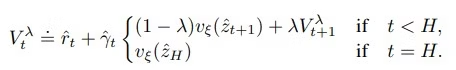

In [ ]:
def calculate_lambda_target(rewards: torch.Tensor, discounts: torch.Tensor, values: torch.Tensor, lambda_: float):
    """
    λ-targetを計算する.

    Params:
    -------
        rewards : torch.Tensor (imagination_horizon, D)
            報酬. 1次元目が時刻tを表しており、2次元目は自由な変数で、想像の軌道を作成するとき入力されるindex.
        discounts : torch.Tensor (imagination_horizon, D)
            割引率. gammaそのままでなくDiscount Modelの出力を掛ける.
        values : torch.Tensor (imagination_horizon, D)
            状態価値.
        lambda_ : float
            λ. 元論文ではλ=0.95

    Returns:
    -------
        V_lambda : torch.Tensor (imagination_horizon, D)
            lambda_targetの値.
    """
    V_lambda = torch.zeros_like(rewards)

    for t in reversed(range(rewards.shape[0])):
        if t == rewards.shape[0] - 1: # t = H(下の条件式)
            V_lambda[t] = rewards[t] + discounts[t] * values[t]
        else:
            V_lambda[t] = rewards[t] + discounts[t] * ((1 - lambda_) * values[t+1] + lambda_ * V_lambda[t+1])

    return V_lambda